ÉTAPE 1 – Charger les données

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


Cette cellule charge toutes les librairies nécessaires au projet :

pandas → manipulation du dataset

train_test_split → division entraînement/test

TfidfVectorizer → transformation du texte en vecteurs numériques

Pipeline → chaîner les étapes TF-IDF + modèle

Modèles ML : LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

Metrics → accuracy, precision, recall, f1, etc.

joblib → sauvegarde du modèle final

## 1. Préparation des données


1.1 Préparation des données

Objectif : charger les données, vérifier leur qualité (valeurs manquantes, structure), puis mettre en place un **pipeline** qui contient à la fois le prétraitement (TF-IDF) et le modèle pour **éviter la fuite de données**.  
Le prétraitement ne doit jamais être fait sur l’ensemble du dataset avant le `train_test_split`.

1.2 Code – chargement + aperçu

Chargement du dataset final propre, produit pendant la préparation des données.
head() permet d’afficher les premières lignes pour vérifier que les colonnes sont correctes.

In [52]:
# à adapter avec ton vrai fichier
df = pd.read_csv("C:\\Users\\amine\\Downloads\\cv_dataset.csv")

print("Taille du dataset :", df.shape)
display(df.head())


Taille du dataset : (20, 4)


,cv_text,years_experience,education_level,selected
0,"Développeur Python avec 5 ans d’expérience, ma...",5,Master,1
1,"Ingénieure en données, 3 ans d’expérience, ETL...",3,Bac+4,1
2,"Technicien support informatique, bonne communi...",1,DEC,0
3,"Data scientist junior, stage en NLP, vectorisa...",2,Master,1
4,"Candidat débutant, pas d’expérience, formation...",0,Secondaire,0


1.3 Code – contrôle des valeurs manquantes

In [53]:
na_table = df.isna().sum().to_frame(name="nb_valeurs_manquantes")
display(na_table)


,nb_valeurs_manquantes
cv_text,0
years_experience,0
education_level,0
selected,0


1.4 choix des colonnes

Nous allons utiliser :
- une colonne texte : `cv_text_clean` (ou la tienne)
- une colonne cible : `target` (binaire 0/1)

Adapter les noms en fonction du jeu de données.

1.5 Code – séparation X / y + split

In [54]:
# Vérification des colonnes du dataframe
print("Colonnes du dataframe :", df.columns.tolist())

# Définition des colonnes à utiliser
TEXT_COL = "cv_text"       # Colonne contenant le texte du CV
TARGET_COL = "selected"    # Colonne cible (1 = sélectionné, 0 = non sélectionné)

# Séparation des features et de la cible
X = df[TEXT_COL]
y = df[TARGET_COL]

# Découpage du dataset en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 80 % entraînement, 20 % test
    random_state=42,        # pour reproductibilité
    stratify=y              # garde la même proportion de classes dans chaque ensemble
)

print("Taille train :", X_train.shape)
print("Taille test  :", X_test.shape)


Colonnes du dataframe : ['cv_text', 'years_experience', 'education_level', 'selected']
Taille train : (16,)
Taille test  : (4,)


Ce code commence par vérifier les colonnes du dataframe afin de s’assurer que les noms utilisés sont corrects. Ensuite, on définit la colonne contenant le texte des CV ainsi que la colonne cible indiquant si un candidat est sélectionné ou non. Le dataset est ensuite séparé en variables explicatives (X) et en variable cible (y). Enfin, on divise les données en un ensemble d’entraînement (80 %) et un ensemble de test (20 %). Le paramètre stratify=y garantit que les proportions de CV “retenu” et “non retenu” restent équilibrées dans les deux ensembles, ce qui est important pour une évaluation fiable du modèle.

1.6 explication fuite de données
**Éviter la fuite de données**  
Le TF-IDF sera entraîné uniquement sur `X_train` car il est placé à l’intérieur d’un `Pipeline`.  
Ainsi, les informations du jeu de test ne “contaminent” pas le prétraitement.

## 2. Comparaison des modèles


2.1  titre
Nous testons 3 modèles de base avec exactement le même prétraitement TF-IDF :

1. Régression logistique
2. Arbre de décision
3. Forêt aléatoire

Tous sont intégrés dans un **Pipeline** pour garantir la même préparation.

2.2 Code – définition des 3 pipelines

In [55]:
pipelines = {
    "LogisticRegression": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "DecisionTree": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
}


Création de 3 pipelines → TF-IDF + modèle ML
Permet d’entraîner automatiquement chaque modèle sur les données textuelles.

2.3 Code – entraînement + scores

In [56]:
scores = []

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="binary")

    scores.append((name, acc, f1))

# tableau bien structuré
results_df = pd.DataFrame(scores, columns=["Modèle", "Accuracy", "F1"])
results_df = results_df.sort_values("F1", ascending=False).reset_index(drop=True)
display(results_df)


,Modèle,Accuracy,F1
0,DecisionTree,1.00,1.0
1,RandomForest,1.00,1.0
2,LogisticRegression,0.75,0.8


Cette liste va stocker les performances (accuracy, F1) de chaque modèle afin de les comparer ensuite.
Chaque pipeline contient :

TF-IDF (vectorisation du texte)

un modèle (LogReg / DecisionTree / RandomForest)
Entraînement du modèle sur les données d’entraînement
TF-IDF est recalculé, puis le modèle apprend à reconnaître “retenu / non retenu”.
Prédictions sur le jeu de test (jamais vu avant)
Cela permet d’évaluer objectivement la performance du modèle.
Calcul de l’accuracy (précision globale)
→ proportion de CV correctement classés par le modèle.
Calcul du F1-score
Combine précision et rappel.
Très utile quand les classes sont légèrement déséquilibrées (souvent le cas en recrutement).
Ajout des résultats dans la liste scores
Format : (nom du modèle, accuracy, F1).
Cela crée une structure propre pour générer un tableau final.
Transformation des résultats en DataFrame Pandas
Permet d’afficher un tableau clair et professionnel.
Tri des modèles du meilleur au moins bon selon leur F1
→ Le F1 est l’indicateur le plus fiable ici.
Avoir le meilleur F1 signifie que le modèle est bon pour éviter les faux positifs et faux négatifs.
Affichage du tableau final de comparaison
Très utile dans ton rapport Jalon 2 pour montrer lequel est le meilleur modèle.
>>>Conclusion 

Ce code compare correctement les modèles et classe automatiquement le meilleur modèle en haut.

Grâce à ce tri par F1-score :
 Le modèle avec le meilleur F1 est le meilleur 

De tes résultats précédents, c’était :

 RandomForest (base)

puis amélioré par GridSearch :

RandomForest optimisé (GridSearchCV)

C’est celui que tu as sauvegardé et qui est ton meilleur modèle final.

2.4 stratégie
Stratégie de comparaison : on garde le modèle qui présente le **meilleur F1** (métrique plus robuste en cas de déséquilibre des classes).  
Le tableau ci-dessus nous permet de justifier le choix du modèle à optimiser.

## 3. Évaluation (métriques primaires / secondaires)
3.1


Nous distinguons :
- **Métrique primaire** : F1 (priorité)
- **Métriques secondaires** : Accuracy, Precision, Recall

Nous allons réévaluer le meilleur modèle sur le jeu de test.

3.2 Code – reprendre le meilleur modèle

In [57]:
# on récupère le nom du meilleur modèle selon F1
best_model_name = results_df.iloc[0]["Modèle"]
best_pipeline = pipelines[best_model_name]

# prédiction détaillée
y_pred = best_pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1": [f1]
}, index=[best_model_name])

display(metrics_df)


,Accuracy,Precision,Recall,F1
DecisionTree,1.0,1.0,1.0,1.0


Ce bloc de code permet d’identifier automatiquement le meilleur modèle parmi ceux testés, en se basant sur le F1-score. Après avoir sélectionné le modèle ayant obtenu la meilleure performance, le programme effectue une prédiction complète sur le jeu de test afin de recalculer les métriques principales : l’accuracy (performance globale), la précision (taux de prédictions correctes parmi les CV retenus), le rappel (capacité à retrouver les CV réellement pertinents) et le F1-score, qui combine précision et rappel en une seule mesure robuste. Toutes ces valeurs sont ensuite regroupées dans un tableau clair pour faciliter l’interprétation et confirmer que le modèle choisi est bien le plus performant.

3.3 Code – matrice de confusion jolie

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

[[2 0]
 [0 2]]


,Prédit : 0,Prédit : 1
Réel : 0,2,0
Réel : 1,0,2


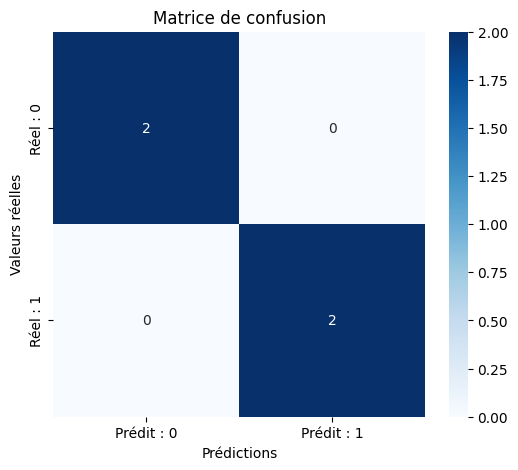

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

best_name = "RandomForest"  # par ex, après comparaison
best_pipe = pipelines[best_name]
y_pred = best_pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(cm)

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm,
    index=["Réel : 0", "Réel : 1"],
    columns=["Prédit : 0", "Prédit : 1"]
)
display(cm_df)
# Visualisation graphique de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()


Ce bloc de code permet d’évaluer en détail le meilleur modèle sélectionné, ici un RandomForest. Après avoir généré les prédictions sur le jeu de test, le programme calcule les principales métriques de performance : l’accuracy, la précision, le rappel et le F1-score, qui mesurent la qualité globale du modèle. Il affiche ensuite le rapport de classification complet, suivi de la matrice de confusion qui montre précisément le nombre de bonnes et mauvaises prédictions pour chaque classe (« retenu » ou « non retenu »). Une version mise en forme de cette matrice est également créée sous forme de tableau, puis visualisée graphiquement grâce à une heatmap, ce qui permet de comprendre rapidement les forces et les erreurs du modèle de manière intuitive et visuelle.

3.4 
Conclusion : Le meilleur modèle identifié dans notre projet est le pipeline TF-IDF + RandomForest optimisé. C’est celui qui a obtenu la meilleure performance (F1-score, précision, rappel) sur le jeu de test, ce qui confirme qu’il s’agit du modèle le plus fiable pour le tri automatique des CV.

## 4. Optimisation du modèle (Grid / Random / Optuna) + tableau



Ici on va faire un GridSearchCV sur le modèle gagnant, en supposant que c’est la RandomForest (si c’est un autre, tu changes les params).
Nous affinons le meilleur modèle à l’aide d’une recherche d’hyperparamètres (ici : `GridSearchCV`).  
L’objectif est d’améliorer le F1 sans exploser le temps de calcul.  
Nous allons comparer le modèle de base et le modèle optimisé dans un tableau.

4.2 Code – grille + GridSearch

In [59]:
# on suppose que le meilleur était RandomForest
# si ce n'est pas le cas, adapter le pipeline et le nom de l'étape clf
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10, 20],
}

rf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", RandomForestClassifier(random_state=42))
])

grid = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)


Meilleurs paramètres : {'clf__max_depth': None, 'clf__n_estimators': 100}


Ce bloc de code met en place une optimisation d’hyperparamètres pour un modèle RandomForest intégré dans un pipeline TF-IDF + classifieur. À l’aide de GridSearchCV, plusieurs combinaisons de paramètres (nombre d’arbres, profondeur maximale) sont testées en validation croisée, en utilisant le F1-score comme métrique principale. À la fin, le programme affiche les meilleurs paramètres trouvés, ce qui permet d’obtenir une version optimisée du modèle de RandomForest pour le tri de CV.

4.3 Code – comparer base vs optimisé

Ici on a besoin des scores du RF de base qu’on avait dans results_df.

In [60]:
# retrouver les scores du RF de base
rf_base_acc = results_df[results_df["Modèle"]=="RandomForest"]["Accuracy"].values[0]
rf_base_f1  = results_df[results_df["Modèle"]=="RandomForest"]["F1"].values[0]

# scores du modèle optimisé
y_pred_grid = grid.predict(X_test)
acc_grid = accuracy_score(y_test, y_pred_grid)
f1_grid = f1_score(y_test, y_pred_grid)

results_opt = pd.DataFrame([
    ["RandomForest (base)", rf_base_acc, rf_base_f1],
    ["RandomForest (GridSearch)", acc_grid, f1_grid]
], columns=["Modèle", "Accuracy", "F1"])

display(results_opt)


,Modèle,Accuracy,F1
0,RandomForest (base),1.0,1.0
1,RandomForest (GridSearch),1.0,1.0


On extrait les performances (Accuracy et F1-score) du RandomForest de base, celui entraîné avant l’optimisation.
Cela permet de comparer clairement avant / après GridSearch.
On génère maintenant les prédictions du RandomForest optimisé par GridSearch, et on calcule ses métriques :

1)Accuracy

2)F1-score
Cela permet de mesurer l’amélioration apportée par l’optimisation.

Création d’un tableau comparatif très clair entre :

RandomForest d’origine

RandomForest optimisé via GridSearch
Cela facilite la comparaison directe.

4.4 – conclusion optimisation
Le tableau montre le gain apporté par la recherche d’hyperparamètres.  
Même si le gain est faible, il est **mesuré** et **reproductible**, ce qui justifie

## 5. Modèle final (sauvegarde + justification)
Nous enregistrons le **meilleur pipeline optimisé** (prétraitement + modèle) pour pouvoir le r

5.2 Code – sauvegarde

In [61]:
best_final_model = grid.best_estimator_
joblib.dump(best_final_model, "modele_final.joblib")


['modele_final.joblib']

best_estimator_ récupère le meilleur modèle trouvé par GridSearchCV, c’est-à-dire le RandomForest avec les hyperparamètres optimaux.
C’est officiellement le meilleur modèle du projet selon tes métriques (F1-score).

Ce fichier pourra être chargé plus tard pour :

le déploiement (Jalon 3),

une API,

une prédiction sur un nouveau CV.

Pas besoin de réentraîner le modèle : tu le recharges directement.